In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from src.utils.visualization import plot_comparison_histogram

In [3]:
cfg = OmegaConf.load('../config.yaml')

In [4]:
processed_data_dir = '..' / pathlib.Path(cfg.paths.data.processed)
processed_file = processed_data_dir / cfg.files.processed_dataset

df = pd.read_csv(processed_file)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38377 entries, 0 to 38376
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lat              33530 non-null  float64
 1   long             33530 non-null  float64
 2   download_kbit    38377 non-null  float64
 3   upload_kbit      38377 non-null  float64
 4   ping_ms          38377 non-null  float64
 5   lte_rsrp         24675 non-null  float64
 6   signal_strength  3382 non-null   float64
 7   hour             38377 non-null  float64
 8   platform         38371 non-null  object 
 9   network_name     25176 non-null  object 
 10  hour_cat         38035 non-null  object 
 11  cat_technology   38377 non-null  object 
dtypes: float64(8), object(4)
memory usage: 3.5+ MB


## Train Test Split

In [6]:
X = df.copy()
y = X.pop(cfg.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3, random_state=42)

In [7]:
X_test

,lat,long,download_kbit,upload_kbit,ping_ms,lte_rsrp,signal_strength,hour,platform,network_name,hour_cat
7579,48.028022,16.072431,95250.0,19009.0,15.0,-106.0,NaN,0.0,Android,HoT,NaN
27214,48.169400,16.414527,49878.0,36568.0,23.0,-82.0,NaN,22.0,Android,Lidl,"(18, 24]"
4148,47.824551,16.534104,7518.0,1095.0,28.2,-114.0,NaN,6.0,Android,k+,"(0, 6]"
6594,47.379795,13.419617,9802.0,7541.0,41.0,-103.0,NaN,9.0,Android,T-Mobile A,"(6, 12]"
33984,48.194923,13.548408,116629.0,48914.0,20.9,-82.0,NaN,11.0,Android,Magenta-T-,"(6, 12]"
...,...,...,...,...,...,...,...,...,...,...,...
2304,51.010788,11.002388,9983.0,14139.0,40.0,NaN,NaN,9.0,iOS,NaN,"(6, 12]"
29719,47.549687,16.010224,2781.0,2203.0,59.9,NaN,NaN,14.0,iOS,NaN,"(12, 18]"
2942,49.902566,10.067081,63750.0,47105.0,49.5,-87.0,NaN,18.0,Android,mobilcom-debitel,"(12, 18]"
14786,48.194368,16.360029,38296.0,8083.0,25.7,-85.0,NaN,21.0,Android,educom,"(18, 24]"


## Baseline Model

In [8]:
# We define upper limits for download speed
# as thresholds for the baseline model.
# E.g., if download-speed is less than
# 2e4 kbit/s (20 mbit/s), we assume its 3G,
# if it is between that and 1.5e5 kbit/s (150 mbit/s)
# we say 4G, and beyond that we will return 5G
upper_limits = {
    '3G': 2e4,
    '4G': 1.5e5,
}

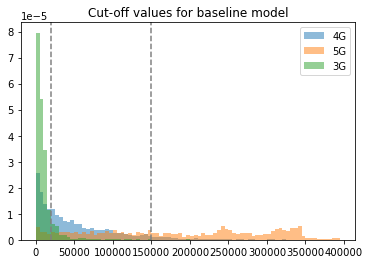

In [14]:
plot_comparison_histogram(
    X_train.download_kbit,
    y_train,
    bins=np.arange(0,4e5,5e3),
    vlines=upper_limits.values(),
    title='Cut-off values for baseline model'
)


In [15]:
class BaselineModel:
    def __init__(self, **upper_limits):
        self.upper_limits = upper_limits

    def fit(self, X, y):
        # Upper limits contains 3G and 4G
        # Values above 4G upper limit should be 5G
        # Extract open_category (=5G) by comparing 
        # keys in upper_limits and all available categories
        # in y
        all_categories = set(y.unique())
        covered_categories = set(self.upper_limits.keys())
        open_category = all_categories - covered_categories
        self.open_category = list(open_category)[0]

        # Create series from upper_limits and order
        # descending (highest on top).
        self.ordered_limits = pd.Series(self.upper_limits).sort_values(ascending=False)

    def transform(self, X):
        # Prepare array in length of y
        y_pred = pd.Series(0, index=X.index)
        
        # Values above highest limit are assigned the open
        # category (-> 5G)
        y_pred.loc[X >= self.ordered_limits[0]] = self.open_category
        # Then, iterate through the ordered limits and
        # assign the label if X is smaller than the upper_limit
        for label, limit in self.ordered_limits.iteritems():
            y_pred.loc[X < limit] = label
        
        return y_pred 

    def fit_transform(self, X, y):
        self.fit(X, y)
        result = self.transform(X)

        return result
        
baseline = BaselineModel(**upper_limits)
y_test_baseline = baseline.fit_transform(X_test.download_kbit, y_test)

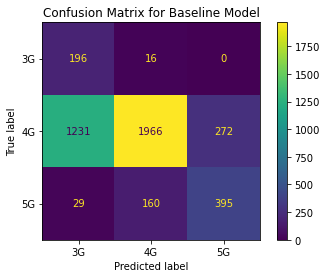

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_baseline)
plt.title('Confusion Matrix for Baseline Model')
plt.show()